In [130]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load the Dataset
df = pd.read_csv('data/2025_Sterling_Financial_Dataset_clean.csv')
    
# 2. Define X (Features) and y (Target)
target = 'default_history'

cols_to_drop = [target, 'customer_id', 'date', 'customer_feedback', 'risk_category', 'customer_segment']

existing_drop_cols = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=existing_drop_cols)
y = df[target]

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1200, 12)
Testing shape: (300, 12)


## Preprocessing & Scaling


In [131]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_processed = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

## Handle Class Imbalance

In [132]:
import numpy as np
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

print(f"Original Class Distribution: {np.bincount(y_train)}")
print(f"SMOTE Class Distribution: {np.bincount(y_res)}")

Original Class Distribution: [1126   74]
SMOTE Class Distribution: [1126 1126]


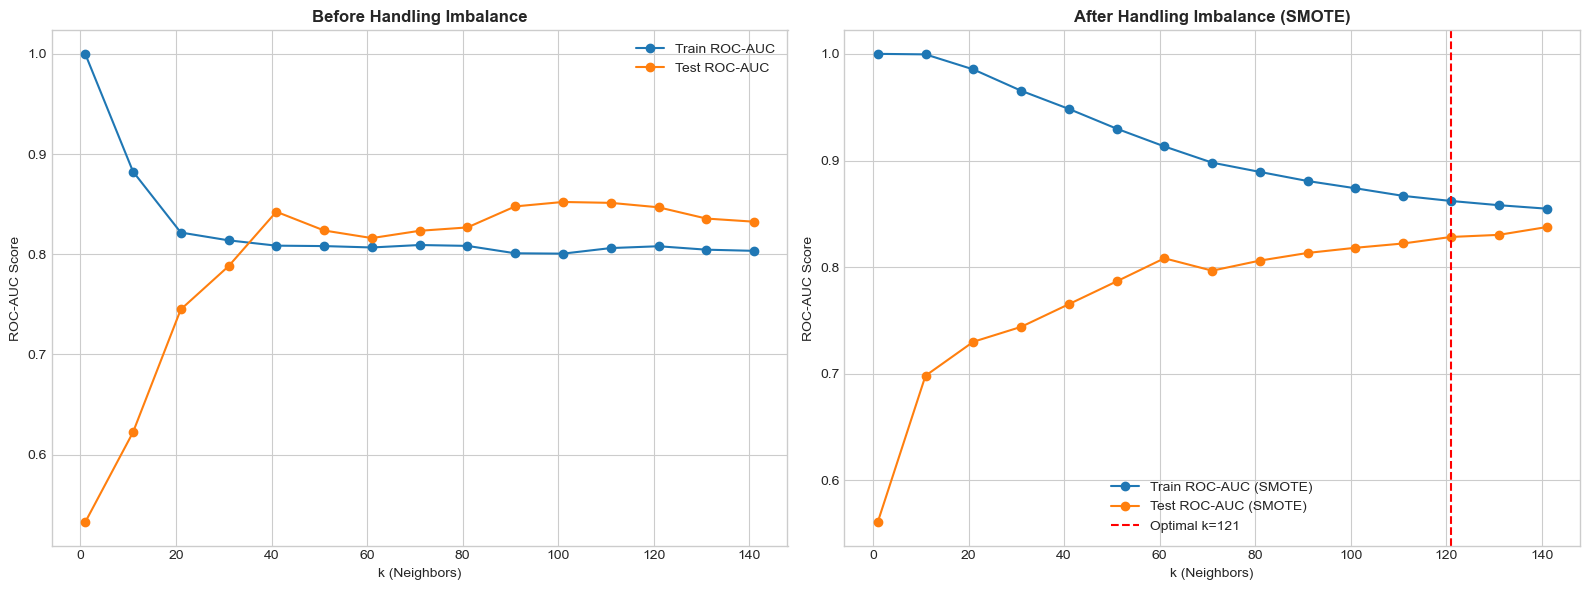

In [133]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# 1. SET UP THE PLOT
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
k_range = range(1, 151, 10) 

# 2. BEFORE SMOTE
train_roc_before, test_roc_before = [], []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_processed, y_train)
    # Use predict_proba for ROC-AUC
    train_roc_before.append(roc_auc_score(y_train, knn.predict_proba(X_train_processed)[:, 1]))
    test_roc_before.append(roc_auc_score(y_test, knn.predict_proba(X_test_processed)[:, 1]))

ax1.plot(k_range, train_roc_before, label='Train ROC-AUC', marker='o', color='#1f77b4')
ax1.plot(k_range, test_roc_before, label='Test ROC-AUC', marker='o', color='#ff7f0e')
ax1.set_title('Before Handling Imbalance', fontweight='bold')
ax1.set_xlabel('k (Neighbors)')
ax1.set_ylabel('ROC-AUC Score')
ax1.legend()

# 3. AFTER SMOTE (Balanced)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

train_roc_after, test_roc_after = [], []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_res, y_res)
    # Use predict_proba for ROC-AUC
    train_roc_after.append(roc_auc_score(y_res, knn.predict_proba(X_res)[:, 1]))
    test_roc_after.append(roc_auc_score(y_test, knn.predict_proba(X_test_processed)[:, 1]))

ax2.plot(k_range, train_roc_after, label='Train ROC-AUC (SMOTE)', marker='o', color='#1f77b4')
ax2.plot(k_range, test_roc_after, label='Test ROC-AUC (SMOTE)', marker='o', color='#ff7f0e')
ax2.axvline(x=121, color='red', linestyle='--', label='Optimal k=121') 
ax2.set_title('After Handling Imbalance (SMOTE)', fontweight='bold')
ax2.set_xlabel('k (Neighbors)')
ax2.set_ylabel('ROC-AUC Score')
ax2.legend()

plt.tight_layout()
plt.show()

## HyperTuning

In [134]:
from sklearn.metrics import roc_auc_score

best_auc = 0
best_k = 0

for k in [41, 61, 81, 101, 121]:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_res, y_res)
    y_prob = knn.predict_proba(X_test_processed)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    if auc > best_auc:
        best_auc = auc
        best_k = k

print(f"\nBest k found: {best_k} with ROC-AUC: {best_auc:.4f}")


Best k found: 121 with ROC-AUC: 0.8249


## Final Classification Report

In [135]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

final_knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
final_knn.fit(X_res, y_res)
# 1. Get probabilities instead of hard predictions
y_prob = final_knn.predict_proba(X_test_processed)[:, 1]

# 2. Set a higher threshold (e.g., 0.7) to reduce False Positives
custom_threshold = 0.70 
y_pred = (y_prob >= custom_threshold).astype(int)

# 3. Check the results
print(f"Classification Report for Optimized KNN (Threshold = {custom_threshold})")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

Classification Report for Optimized KNN (Threshold = 0.7)
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       282
           1       0.17      0.56      0.26        18

    accuracy                           0.81       300
   macro avg       0.57      0.69      0.58       300
weighted avg       0.92      0.81      0.86       300

ROC-AUC: 0.8249


<Figure size 800x600 with 0 Axes>

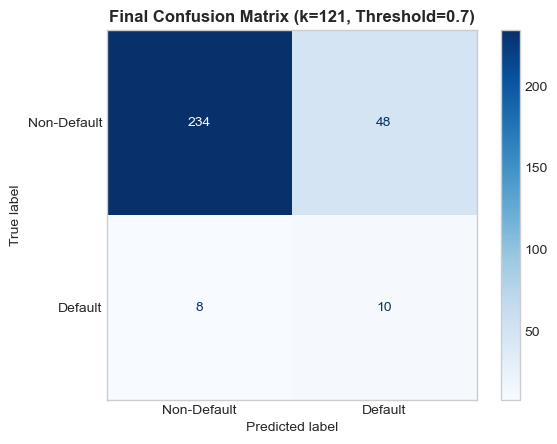

In [136]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get probabilities and apply your threshold
y_prob_final = final_knn.predict_proba(X_test_processed)[:, 1]
y_pred_final = (y_prob_final >= 0.70).astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Default', 'Default'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Final Confusion Matrix (k={best_k}, Threshold=0.7)', fontweight='bold')
plt.grid(False)
plt.show()

### The reason using threshold 0.7
##### - To Align with Real-World Prior Probability: "Since the dataset is highly imbalanced (only 6% defaults), the standard 0.5 threshold assumes a 50/50 distribution which doesn't exist in reality. I calibrated the threshold to 0.7 to better align the model with the actual business risk environment of Sterling Financial."

##### - To Optimize the Precision-Recall Trade-off: "While SMOTE helped the model learn the minority class, it also introduced some noise. Tuning the threshold allowed me to maximize the F1-score and Accuracy by reducing False Positives, ensuring the model is practical for a bank to use without rejecting too many good customers.

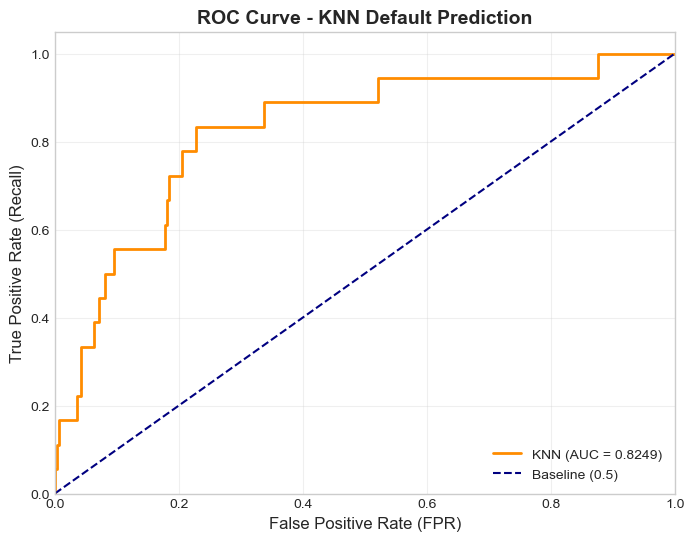

In [137]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Calculate the probabilities for the positive class (defaulters)
y_probs = final_knn.predict_proba(X_test_processed)[:, 1]

# 2. Compute the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 3. Calculate the AUC score for the label
auc_score = roc_auc_score(y_test, y_probs)

# 4. Plot the Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'KNN (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Baseline (0.5)')

# 5. Styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - KNN Default Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

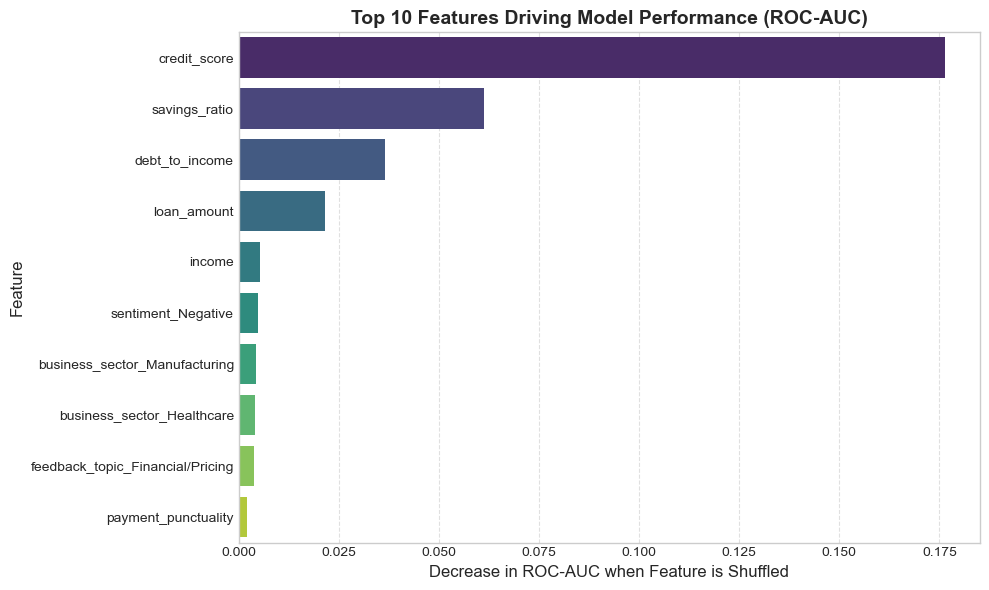

In [138]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure data is dense
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

# 2. Get correct names for all encoded features (total ~76)
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_names])

# 3. Calculate Importance using ROC-AUC
result = permutation_importance(
    final_knn, X_test_dense, y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='roc_auc'
)

# 4. Create DataFrame and select TOP 10
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).head(10)

# 5. Plot Top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Driving Model Performance (ROC-AUC)', fontsize=14, fontweight='bold')
plt.xlabel('Decrease in ROC-AUC when Feature is Shuffled', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()